In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Lecture 19 ##

## Birth weights

In [2]:
#Birth weight in ounces; Maternal Pregnancy weight in pounds
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = baby.select('Birth Weight', 'Maternal Smoker')
smoking_and_birthweight

Birth Weight,Maternal Smoker
120,False
113,False
128,True
108,True
136,False
138,False
132,False
120,False
143,True
140,False


In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


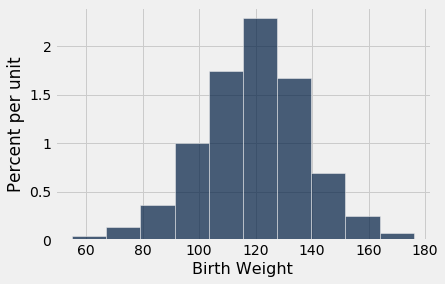

In [5]:
smoking_and_birthweight.hist('Birth Weight')

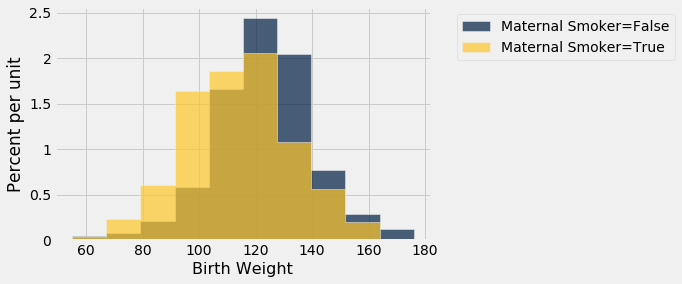

In [6]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [7]:
observed_means = smoking_and_birthweight.group('Maternal Smoker', np.average)
observed_means

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [8]:
observed_diff = observed_means.column(1).item(0) - observed_means.column(1).item(1)
observed_diff

9.266142572024918

In [9]:
def diff_between_group_means(tbl):
    means = tbl.group('Maternal Smoker', np.average)
    return means.column(1).item(0) - means.column(1).item(1)

In [10]:
# PLAN:

# Shuffle birth weights

# Assign some to group A and some to group B

# Find difference between averages of the two groups (statistic)

# Repeat

In [11]:
weights = smoking_and_birthweight.select('Birth Weight')
weights

Birth Weight
120
113
128
108
136
138
132
120
143
140


In [12]:
smoking = smoking_and_birthweight.select('Maternal Smoker')
smoking

Maternal Smoker
False
False
True
True
False
False
False
False
True
False


In [13]:
# Shuffle birth weights
shuffled_weights = weights.sample(with_replacement=False).column(0)
shuffled_weights

array([145, 104, 121, ..., 128, 130, 119])

In [14]:
# Assign some to group A and some to group B
shuffled = smoking.with_column('Shuffled weights', shuffled_weights)
shuffled

Maternal Smoker,Shuffled weights
False,145
False,104
True,121
True,148
False,89
False,144
False,97
False,139
True,121
False,112


In [15]:
# Find difference between averages of the two groups (statistic)
diff = diff_between_group_means(shuffled)
diff

-0.07405883876471364

In [16]:
# Repeat
diffs = make_array()
for i in np.arange(2000):
    shuffled_weights = weights.sample(with_replacement=False).column(0)
    shuffled = smoking.with_column('Shuffled weights', shuffled_weights)
    means = shuffled.group('Maternal Smoker', np.average)
    diff = means.column(1).item(0) - means.column(1).item(1)
    diffs = np.append(diffs, diff)

diffs

array([-3.36512942,  1.76107074, -1.59081311, ...,  1.43911818,
       -0.35666164, -0.7072322 ])

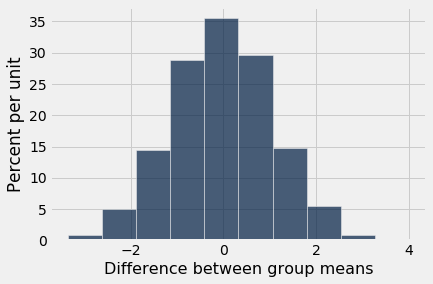

In [17]:
Table().with_column('Difference between group means', diffs).hist()

In [18]:
observed_diff

9.266142572024918

## Deflategate ##

In [19]:
# Pressure measured in "pounds per square inch" (psi)
# Two officials (Blakeman and Prioleau) measured pressure 
# of balls at half-time
# Most of Colts balls were not measured
football = Table.read_table('deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


In [20]:
#Take average of two measurements
football = football.select('Team').with_column(
    'Combined', (football.column('Blakeman')+football.column('Prioleau'))/2
    )
football.show()

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


In [21]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [22]:
#Before the start of AFC game, ball pressures were measured
#NFL rule:  ball pressure between 12.5 and 13.5 psi
#Patriots' balls were all about 12.5 psi
#Colts' balls were about 13.0 psi
start = np.append(12.5 * np.ones(11), 13 * np.ones(4))
start

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

In [23]:
# Some deflation is normal during game; investigate the pressure drop
drop_values = start - football.column('Combined')
drop_values

array([0.85 , 1.475, 1.175, 1.65 , 1.225, 0.725, 0.425, 1.175, 1.35 ,
       1.8  , 1.375, 0.475, 0.475, 0.275, 0.65 ])

In [24]:
football = football.drop('Combined').with_column('Drop', drop_values)
football.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [25]:
means_tbl = football.group('Team', np.average)
means_tbl

Team,Drop average
Colts,0.46875
Patriots,1.20227


In [26]:
drop_avgs = means_tbl.column('Drop average')
observed_difference = drop_avgs.item(1) - drop_avgs.item(0)
observed_difference
#Large values imply larger drop for Patriots

0.733522727272728

In [27]:
# Do the 11 Patriot balls look like a random sample of the 15 balls?
# Could this difference be due to chance?

In [28]:
group_labels = football.select('Team')
drops = football.select('Drop')
group_labels

Team
Patriots
Patriots
Patriots
Patriots
Patriots
Patriots
Patriots
Patriots
Patriots
Patriots


In [29]:
differences = make_array()

for i in np.arange(20000):
    shuffled_drops = drops.sample(with_replacement = False).column('Drop')
    shuffled_tbl = group_labels.with_column('Shuffled Drop', shuffled_drops)
    means_tbl = shuffled_tbl.group('Team', np.average)
    drop_avgs = means_tbl.column('Shuffled Drop average')
    new_diff = drop_avgs.item(1) - drop_avgs.item(0)
    differences = np.append(differences, new_diff)

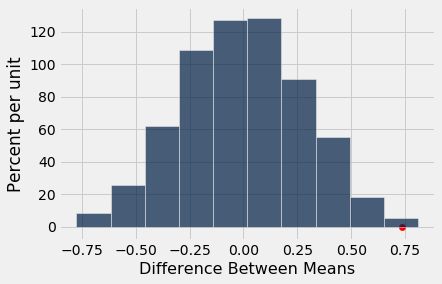

In [30]:
Table().with_column('Difference Between Means', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=40);

In [31]:
np.count_nonzero(differences >= observed_difference) / 20000

0.00235

In [32]:
shuffled_tbl.show()

Team,Shuffled Drop
Patriots,1.35
Patriots,1.375
Patriots,0.85
Patriots,0.475
Patriots,0.275
Patriots,1.175
Patriots,1.65
Patriots,1.175
Patriots,1.475
Patriots,1.8
